# Diplomaterv 1 - 2025
- Konzulens: Unyi Dániel


## Csomagok telepítése

In [ ]:
!python --version

Python 3.12.12


In [ ]:
!pip install --no-cache-dir \
    torchvision==0.23.0 \
    torchaudio==2.8.0 \
    --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 269.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 173.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 278.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 MB 307.4 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.5.0
    Uninstalling triton-3.5.0:
      Successfully uninstalled triton-3.5.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.27.5
    Uninstalling nvidia-nccl-cu12-2.27.5:
      Successfully uninstalled nvidia-nccl-cu12-2.27.5
  Attempting uninstall: torch
    Found existing installation: torch 2.9.0+cu126
    Uninstalling torch-2.9.0+cu126:
      Successfully uninstalled torch-2.9.0+cu126
  Attempting uninstall: torchv

In [ ]:
#Gráfok létrehozása
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00


In [ ]:
!pip install --no-cache-dir \
    pyg_lib \
    torch_scatter \
    torch_sparse \
    torch_cluster \
    torch_spline_conv \
    -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 125.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
# Metódusok kidolgozása
import numpy as np
import pandas as pd
#Ábrázolás
import matplotlib.pyplot as plt
import seaborn as sns

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GAE, VGAE
import networkx
import matplotlib.pyplot as plt

from tqdm import tqdm


## Adatelőkészítés

In [ ]:
def MNIST_data_loading():
  transform = ToTensor()
  train_data = datasets.MNIST('/root',
                              train=True,
                              download=True,
                              transform=transform)
  test_data = datasets.MNIST('/root',
                                train=False,
                                download=True,
                                transform=transform)
  return (train_data, test_data)

## Autoencoder készítése

### Vanilia

In [ ]:
class CNNAutoCoder(nn.Module):
    def __init__(self, channel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(channel_size, 32,  kernel_size=3, stride=2, padding=1) # 14 x 14
        self.conv2 = nn.Conv2d(32, 64,  kernel_size=3, stride=2, padding=1) # 7 x 7
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # 6 x 6
        self.conv4 = nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=1) # 3 x 3
        self.fc = nn.Linear(256* 3* 3, 64)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = x
        return output

## Módszerek a hasonlósági gráf felépítésére

### Távolsági metódusok

In [ ]:
def p_norm_distance_index(latent, p=2, k=3):
    diff = latent.unsqueeze(1) - latent.unsqueeze(0)
    dist = diff.norm(p=p, dim=2)
    dist = dist + torch.eye(dist.size(0), device=dist.device) * 1e9
    knn = torch.topk(dist, k, dim=1, largest=False).indices  # [N, k]
    return knn

def cosine_similarity_index(latent, k=3):
    normed = F.normalize(latent, p=2, dim=1)
    sim = torch.matmul(normed, normed.T)
    sim = sim - torch.eye(sim.size(0), device=sim.device) * 2
    knn = torch.topk(sim, k, dim=1, largest=True).indices
    return knn

def create_edge_index(knn):
    N, k = knn.shape
    row = torch.arange(N, device=knn.device).repeat_interleave(k)
    col = knn.reshape(-1)
    edge_index = torch.stack([row, col], dim=0)
    return edge_index.long()

## Gráfok létrehozása

In [ ]:
def graph_creating(latens_vectors, neighb_method, p=2):
  if neighb_method == 'cosine':
    top_neighbours = cosine_similarity_index(latens_vectors)
  elif neighb_method == 'p_norm':
    top_neighbours = p_norm_distance_index(latens_vectors, p=p)
  edge_index = create_edge_index(top_neighbours)
  data = Data(x= latens_vectors, edge_index=edge_index)
  data.num_classes = 10
  return data

## GNN létrehozása

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self,num_features, num_classes):
    super().__init__()
    self.conv1 = GCNConv(
        num_features, 32
    )
    self.conv2 = GCNConv(
        32, num_classes
    )

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)
    return x

## Teljes modell

In [ ]:
class FewShotModel(nn.Module):
  def __init__(self, device):
    super(FewShotModel, self).__init__()
    self.encoder = CNNAutoCoder(1).to(device)
    self.classifier = GCN(64, 10).to(device)
  def forward(self, x, method_similar, p_n):
    x = self.encoder(x)
    x = graph_creating(x, method_similar, p_n)
    x = self.classifier(x)
    return x


## Összeállítás (egyben)

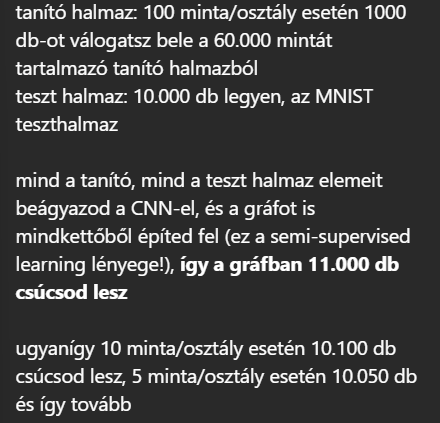

### Hiperparaméterek

In [ ]:
#max_image_labeled_class = [100] # How many labeled images are in each classes.
max_image_labeled_class = [1,2,5,10,20,50,100] # How many labeled images are in each classes.
#train_size = 10
#validation_size = 1200
test_size = 2000
K = 3 #How many edges does have each nodes? (KNN)

method_similar = 'p_norm'
p_n_vectors = [2]

epochs_max = 2500
epochs = np.arange(epochs_max+1, step=10)[1:] # Adott epoch-ban megnézi, hogy mennyire javult a modellt pontosség metrikával
#patience = 150

accuses = []

train_data, test_data = MNIST_data_loading()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.92MB/s]


### Maszkolás, tanítás, tesztelés

In [ ]:
from google.colab import files
#Validációval együtt
#validation_images = test_data.data[:validation_size].unsqueeze(1).float() / 255.0
#validation_targets = test_data.targets[:validation_size]
#test_images = test_data.data[validation_size:(validation_size+test_size)].unsqueeze(1).float() / 255.0
#test_targets = test_data.targets[validation_size:(validation_size+test_size)]


#Csak teszttel
test_images = test_data.data[:test_size].unsqueeze(1).float() / 255.0
test_images = test_images.to(device)
test_targets = test_data.targets[:test_size].to(device)
for p_n in p_n_vectors:
  for max_label in max_image_labeled_class:
    #Tanító halmaz maszkolása
    indexs = np.arange(len(train_data))
    train_targets_index_bool = [train_data.targets==target for target in range(10)]# Choosing X images from each classes as labeled
    train_targets_indexs = [np.asarray(indexs[index_bool]) for index_bool in train_targets_index_bool]
    train_mask_index = np.hstack(np.array([train_targets_indexs[target][:max_label] for target in range(10)])) #Labeling
    train_images = train_data.data[train_mask_index].unsqueeze(1).float() / 255.0
    train_images = train_images.to(device)
    train_targets = train_data.targets[train_mask_index]
    train_targets = train_targets.to(device)
    model = FewShotModel(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_acc = -1
    best_epoch = -1
    for epoch in tqdm(range(epochs_max+1), ascii=True, desc=f"p: {p_n}"):
      model.train()
      optimizer.zero_grad()
      train_test_images =  torch.cat((train_images, test_images), dim=0).to(device)
      train_mask_index = torch.arange(len(train_images)).to(device)
      out = model(train_test_images, method_similar, p_n)
      loss = F.cross_entropy(out[train_mask_index], train_targets)
      loss.backward()
      optimizer.step()
      if epoch in epochs:
        with torch.no_grad():
          model.eval()
          out = model(test_images, method_similar, p_n)
          pred = out.argmax(dim=1)
          correct = pred.eq(test_targets).sum().item()
          acc = correct / len(test_targets)
          if best_acc < acc:
            best_acc = acc
            best_epoch = epoch
    accuses.append({"max_label":max_label ,"epoch":best_epoch, "acc":best_acc})
  pd.DataFrame(accuses).to_csv(f"p_{p_n}.csv")
  files.download(f"p_{p_n}.csv")
  accuses = []

p: 2: 100%|##########| 2501/2501 [04:43<00:00,  8.82it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>